# <font color="darkgray">Time Series Quantum Autoencoders</font><br>Data Generation (Mackey-Glass)
*Data generated for TS QAE in PennyLane with angle encoding of TS sliding windows*<br>

**Author:** Jacob Cybulski<br>
**Date:** August 2023 - June 2025<br>
**Aims:** <br>
The goal of this notebook is to build data for a TS QAE.<br>
Generated data is structured into a series of overlapping sliding windows.<br>
Both pure and noisy versions of data are generated.

## Data
In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).

## Initial settings

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from qae_utils.Charts import multi_plot_flat_ts
from qae_utils.Window import ts_calc_noise
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg

from matplotlib import set_loglevel
set_loglevel("error")

## Prepare windowed TS data
*Values need to be mapped into qubit state angles, in the range of [0+m..pi-m] where m is some small margin (e.g. 0.05)*

### Prepare time series

In [3]:
## Software version
major_version = 6
minor_version = 0

### Mmackey-Glass settings
beta=0.25                           # Larger beta = stronger oscillations
gamma=0.1                           # Keeps damping moderate
n=10                                # Standard nonlinearity
tau=15                              # Introduces chaos (try 17–30 for interesting behavior)
dt=1.0                              # Coarse step (creates irregularities due to Euler integration)
T=300                               # 300 steps (since dt=1.0, T=300 gives 300 values)

### Data settings
split = 0.75
samples = int(T / dt)               # Total number of samples
train_size = int(samples*split)     # Use the first train_size points for training
test_size = samples - train_size    # Use the next test_size points for testing

wind_size = 8                       # Sliding windows of this size to be generated
wind_step = 4                       # Each window to be offset by that much

### Data encoding
margin = 0.2                        # In case we wanted to be away from edges
scale_low = 0+margin                # Lower end of angle encoded values
scale_high = math.pi - margin       # Higher end of angle encoded values
noise = 0.3                         # Absolute max error

print(f'Samples: all={samples}, training={train_size}, testing={test_size}')

Samples: all=300, training=225, testing=75


### Generate TS data

In [4]:
def scale_values(x, new_min=0, new_max=1):
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

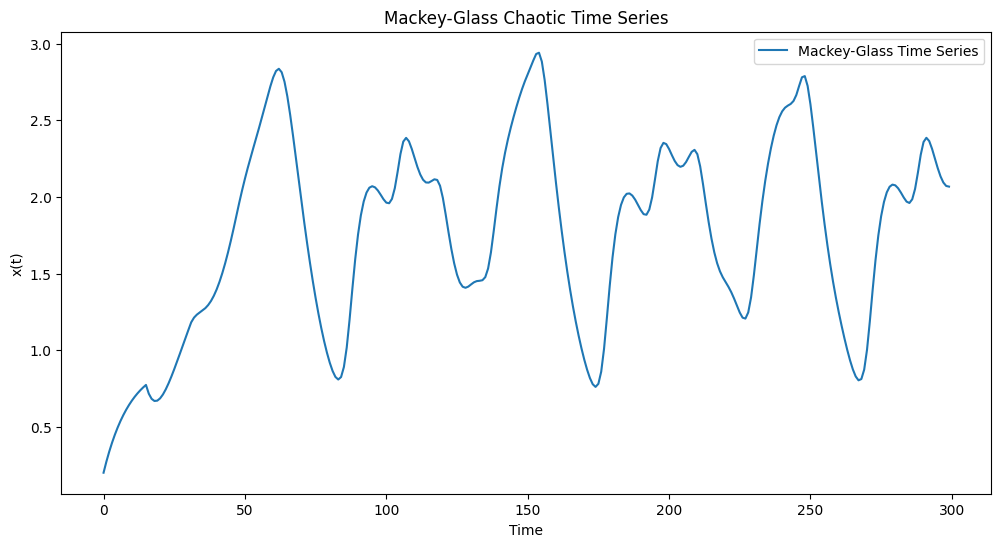

In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
y = mackey_glass(beta=beta, gamma=gamma, n=n, tau=tau, dt=dt, T=T)
y = scale_values(y, new_min=scale_low, new_max=scale_high)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
# plt.ylim(0, math.pi+0.3)
plt.legend()
plt.show()

### Preparation of trainig and testing data partitions
Note that windowsof size _**wind_size**_ overlap by _**wind_step**_ !

In [6]:
### Create pure data, to be done once only
y_ts = ts_wind_make(y, wind_size, wind_step)
X_ts = np.array([i*wind_step for i in range(len(y_ts))])
X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

In [7]:
### Create noisy data, this needs to be done in training at each iteration
y_noisy_ts = ts_wind_make(y, wind_size, wind_step, noise=noise)
X_noisy_ts = X_ts # they are just sequence numbers
X_train_noisy_ts, y_train_noisy_ts, X_test_noisy_ts, y_test_noisy_ts = ts_wind_split(X_noisy_ts, y_noisy_ts, split)
calc_noise, _, _ = ts_calc_noise(y_ts, y_noisy_ts)

In [8]:
### What data looks like

from pprint import pprint

print('\nTraining windows\n')
print(f'Starting window positions / X_train_ts:')
pprint(X_train_ts[0:3])
print()
print(f'Selected pure windows / y_train_ts:')
pprint(y_train_ts[0:3])
print()
print(f'Selected noisy windows / y_train_noisy_ts:')
pprint(y_train_noisy_ts[0:3])
print()

print('\nTesting windows\n')
print(f'Starting window positions / X_test_ts:')
pprint(X_test_ts[0:3])
print()
print(f'Selected pure windows / y_test_ts:')
pprint(y_test_ts[0:3])
print()
print(f'Selected noisy windows / y_test_noisy_ts:')
pprint(y_test_noisy_ts[0:3])
print()


Training windows

Starting window positions / X_train_ts:
array([0, 4, 8])

Selected pure windows / y_train_ts:
array([[0.2       , 0.27217217, 0.33712711, 0.39558657, 0.44820008,
        0.49555224, 0.53816918, 0.57652443],
       [0.44820008, 0.49555224, 0.53816918, 0.57652443, 0.61104415,
        0.6421119 , 0.67007287, 0.69523775],
       [0.61104415, 0.6421119 , 0.67007287, 0.69523775, 0.71788614,
        0.73826969, 0.75661489, 0.77312557]])

Selected noisy windows / y_train_noisy_ts:
array([[-0.04818554,  0.54280696,  0.43159452,  0.62923989,  0.57450573,
         0.25489282,  0.55096529,  0.61742135],
       [ 0.57450573,  0.25489282,  0.55096529,  0.61742135,  0.56597952,
         0.69155807,  0.92765519,  0.91519865],
       [ 0.56597952,  0.69155807,  0.92765519,  0.91519865,  0.70780481,
         0.65547811,  0.9867305 ,  0.47636016]])


Testing windows

Starting window positions / X_test_ts:
array([224, 228, 232])

Selected pure windows / y_test_ts:
array([[1.29024503, 1.

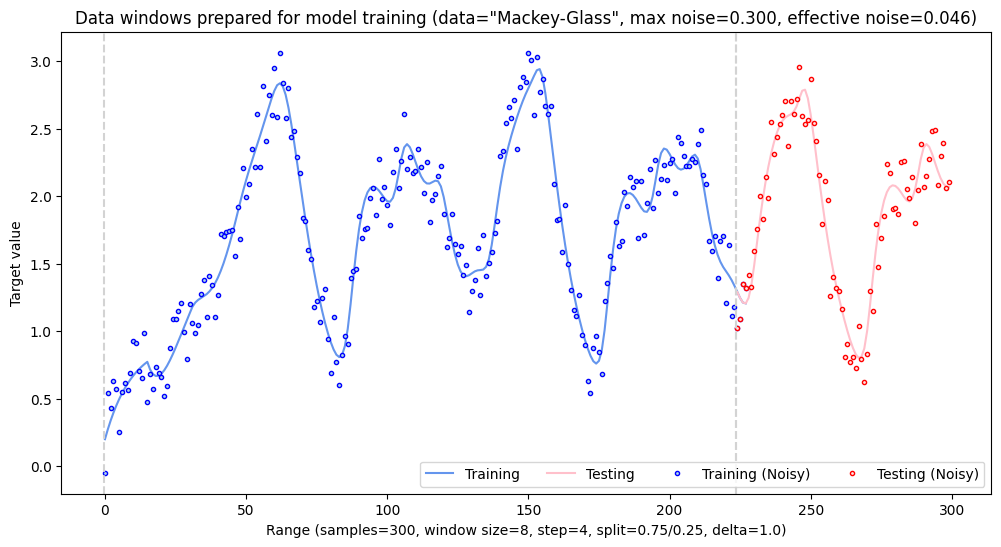

In [9]:
### Plot generated windows series
#   Note that as windows overlap, so the average of overlapping y values will be taken
#   This averaging should be used with caution as it may alter the (perception) of results

### This list indicates the starting point of each series
X_list = [X_train_ts[0], X_test_ts[0], X_train_noisy_ts[0], X_test_noisy_ts[0]]

### This is the list of flattened series to be plotted
y_list = [
    ts_wind_flatten_avg(y_train_ts, wind_step),
    ts_wind_flatten_avg(y_test_ts, wind_step),
    ts_wind_flatten_avg(y_train_noisy_ts, wind_step),
    ts_wind_flatten_avg(y_test_noisy_ts, wind_step)]

### Plot all selected series in a particular way
#   Note that image format in EPS is required by some journals
print()
multi_plot_flat_ts(y_list, X_list=X_list,
    colors = ['cornflowerblue', 'pink', 'blue', 'red'], marker_colors=['white', 'white', 'lightblue', 'mistyrose'],
    labels = ['Training', 'Testing', 'Training (Noisy)', 'Testing (Noisy)'], #ylim=(0.1, 3.2),
    lines = ['solid', 'solid', 'none', 'none'], markers = ['none', 'none', '.', '.'], legend_cols=4,
    title=f'Data windows prepared for model training (data="Mackey-Glass", max noise={noise:0.3f}, effective noise={calc_noise:0.3f})',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step}, split={split}/{1-split}, delta={dt})',
    save_plot=f'logs/figures/sample_data_train_test.eps')
print()

# Software (Linux)

In [10]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
